<a href="https://colab.research.google.com/github/marioTavFer/somePython/blob/main/unsupervised_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisando o mercado acionário brasileiro com aprendizado não supervisionado no Python

Como identificar os fatores significativos que influenciam a variabilidade nos retornos de ações individuais? Como comparar esses fatores ao selecionar empresas de setores distintos? Neste artigo, aplicamos a Análise de Componentes Principais para examinar ações que compõem o índice bovespa, com o objetivo de identificar os fatores estatísticos relevantes. Usamos o Python como ferramenta para aplicar a análise.

Um tópico importante na análise de séries temporais multivariadas é o estudo da estrutura de covariância (ou correlação) das séries. Por exemplo, a estrutura de covariância de uma série de retornos desempenha um papel importante na seleção de portfólio. Isto porque, dados multivariados frequentemente exibem padrões semelhantes, indicando a existência de uma estrutura comum oculta. A análise fatorial estatística é um desses métodos simplificadores disponíveis na literatura. O objetivo da análise fatorial estatística é identificar, a partir dos dados observados, alguns fatores que podem explicar a maior parte das variações na matriz de covariância ou correlação dos dados.

# Como usar o PCA em análise de investimentos?

O PCA desempenha um papel fundamental na criação de estratégias de investimento e na seleção de portfólio. Ele nos permite isolar os fatores estatísticos subjacentes que influenciam os retornos das ações em uma carteira. Esses fatores, frequentemente chamados de "fatores alpha," são essenciais porque geram retornos que não podem ser atribuídos simplesmente ao desempenho do mercado ou a um índice de referência.


A utilização dos fatores alpha identificados pelo PCA pode ser estratégica. Primeiramente, isolamos esses componentes chave. Em seguida, adotamos uma abordagem de compra e venda seletiva: compramos as ações que têm maior exposição a um fator específico e vendemos aquelas com menor exposição a esse mesmo fator. Isso nos permite criar portfólios otimizados que visam aproveitar ao máximo as fontes de retorno identificadas pelos fatores.


Essa metodologia de seleção de portfólio baseada em fatores estatísticos oferece uma abordagem poderosa para gestores de investimentos, permitindo-lhes tomar decisões mais informadas e melhorar o desempenho da carteira. Ela é especialmente útil para diversificar e gerenciar o risco.

# Exemplo:

Como exemplo, importamos os dados do preço de fechamento ajustado das ações que compõe o índice bovespa na data 09/07/2024, consistindo em 86 empresas. Há a retirada de dados faltantes, resultando em uma amostra com menor quantidade de empresas. Utiliza-se o retorno simples padronizados dos preços para estimar o PCA.



# 1. Carrega Bibliotecas

In [ ]:
# Bibliotecas
import requests
import pandas as pd
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# 2. Coleta os dados para o portfólio

In [ ]:
# Tickers
url_tickers_b3 = (
    "https://sistemaswebb3-listados.b3.com.br/indexProxy/indexCall/" +
    "GetTheoricalPortfolio/eyJwYWdlTnVtYmVyIjoxLCJwYWdlU2l6ZSI6" +
    "OTk5OSwibGFuZ3VhZ2UiOiJwdC1iciIsImluZGV4IjoiSUJPViJ9"
)

df_tickers = pd.DataFrame(requests.get(url_tickers_b3, verify = False).json()["results"])
df_tickers["cod"] = df_tickers["cod"] + ".SA"

# Cotações
df_cotacoes = yf.download(
    tickers = df_tickers["cod"].to_list(),
    start = '2021-01-01',
    end = '2024-06-01'
    )[["Adj Close"]]

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sistemaswebb3-listados.b3.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
[*********************100%%**********************]  86 of 86 completed


# Pre Processamento

In [ ]:
# Remove as colunas que possuem mais que 5 valores NAs
na_counts = df_cotacoes.isna().sum()
cols_to_drop = na_counts[na_counts > 5].index
df = df_cotacoes.drop(columns=cols_to_drop)

In [ ]:
# Cria retorno simples
returns = df.pct_change().dropna()
scaler = StandardScaler()

# Ajustar e transformar os dados
returns_scaled = scaler.fit_transform(returns)
returns_scaled_df = pd.DataFrame(returns_scaled, index=returns.index, columns=returns.columns)['Adj Close']

# 3. Ajuste do modelo PCA

In [ ]:
# Ajuste do PCA
pca = PCA(n_components = 7)
pca.fit(returns_scaled_df)

PCA(n_components=7)

In [ ]:
# obtém as variâncias e os componentes
pct = pca.explained_variance_ratio_
pca_components = pca.components_

O primeiro gráfico à esquerda abaixo expõe a contribuição de cada um dos sete componentes em relação a variância total, enquanto o segundo, ao lado direito, acumula a contribuição da variância de cada componente.


O primeiro componente explica boa parte da variação dos retornos do portfólio. Usualmente, esse fator representa o movimento do portfólio de mercado. O segundo componente explica uma fração menor dos retornos, e os componentes seguintes seguem um decaimento. Usualmente esse fatores representam a variabilidade causada pelos setores e valores intrínsecos às companhias.


Pelo gráfico de contribuição acumulada, podemos ver que os sete fatores explicam mais ou menos 50% da variabilidade dos retornos do portfólio.

(0.0, 100.0)

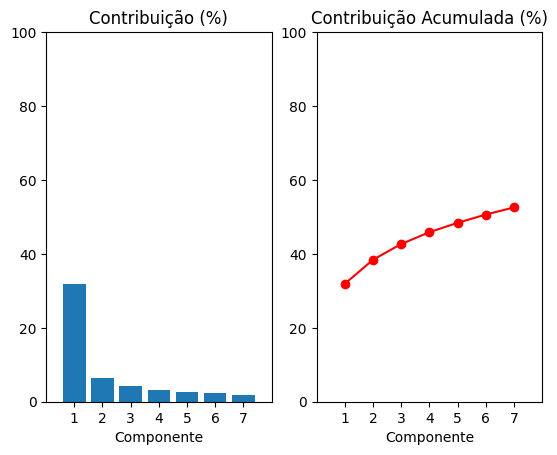

In [ ]:
# Visualiza a contribuição de fatores e o acumulado
cum_pct = np.cumsum(pct)
x = np.arange(1,len(pct)+1,1)

plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title('Contribuição (%)')
plt.xlabel('Componente')
plt.xticks(x)
plt.xlim([0, 8])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, 'ro-')
plt.title('Contribuição Acumulada (%)')
plt.xlabel('Componente')
plt.xticks(x)
plt.xlim([0, 8])
plt.ylim([0, 100])

# 4. Isolar os Fatores

Existem forças que movem os preços das ações que não podemos ver. Esses fatores latentes são captados por meio do PCA e isolados como componentes principais. O mercado de ações (portfólio de mercado) em geral é geralmente um forte impulsionador dos retornos. As forças macroeconômicas, como as taxas de juro, desemprego e PIB também impulsionam os retornos. O PCA permite isolar esses fatores estatísticos para ter uma ideia de quanto o retorno do portfólio vem dessas características não observadas.

Para obter os valor dos fatores ao longo do tempo, multiplicamos os retornos da carteira pelo PCA. A função `dot` garante que cada retorno seja multiplicado por cada um dos componentes. a função `T` transpõe o DataFrame. O DataFrame resultante fornece quanto do retorno do portfólio daquele dia é resultado de cada um dos três fatores.

In [ ]:
# transforma o data frame em array
X = np.asarray(returns_scaled_df)

# Produto dos retornos pelos componentes (transposto)
factor_returns = X.dot(pca_components.T)

# cria o df dos fatores
factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3", "f4", "f5", "f6", "f7"],
    index=returns_scaled_df.index,
    data=factor_returns
)

factor_returns

,f1,f2,f3,f4,f5,f6,f7
Date,,,,,,,
2021-01-05,-1.108860,2.896603,1.281514,-0.255315,0.243229,-1.428277,0.458381
2021-01-06,-3.491441,7.082590,-3.585869,-1.923703,-0.358675,1.920102,-1.028035
2021-01-07,2.465967,8.968370,1.673936,-3.270679,1.561470,2.261528,2.552979
2021-01-08,10.592172,-3.457404,0.064703,6.152792,-1.277673,-0.094784,2.409986
2021-01-11,-7.166557,0.220137,3.647343,-1.005562,1.256718,-1.298194,0.875556
...,...,...,...,...,...,...,...
2024-05-24,-0.895982,0.285142,-0.741098,0.488588,-1.008695,0.171507,-1.769085
2024-05-27,-0.125990,0.107204,0.187958,-0.431010,-0.026529,-0.889498,0.728957
2024-05-28,-2.406948,-0.224233,-0.609443,-0.805815,0.776504,-0.969190,0.036661


Pelo gráfico abaixo, podemos ver o valor do primeiro fator em relação aos ativos.

<Axes: xlabel='Ticker'>

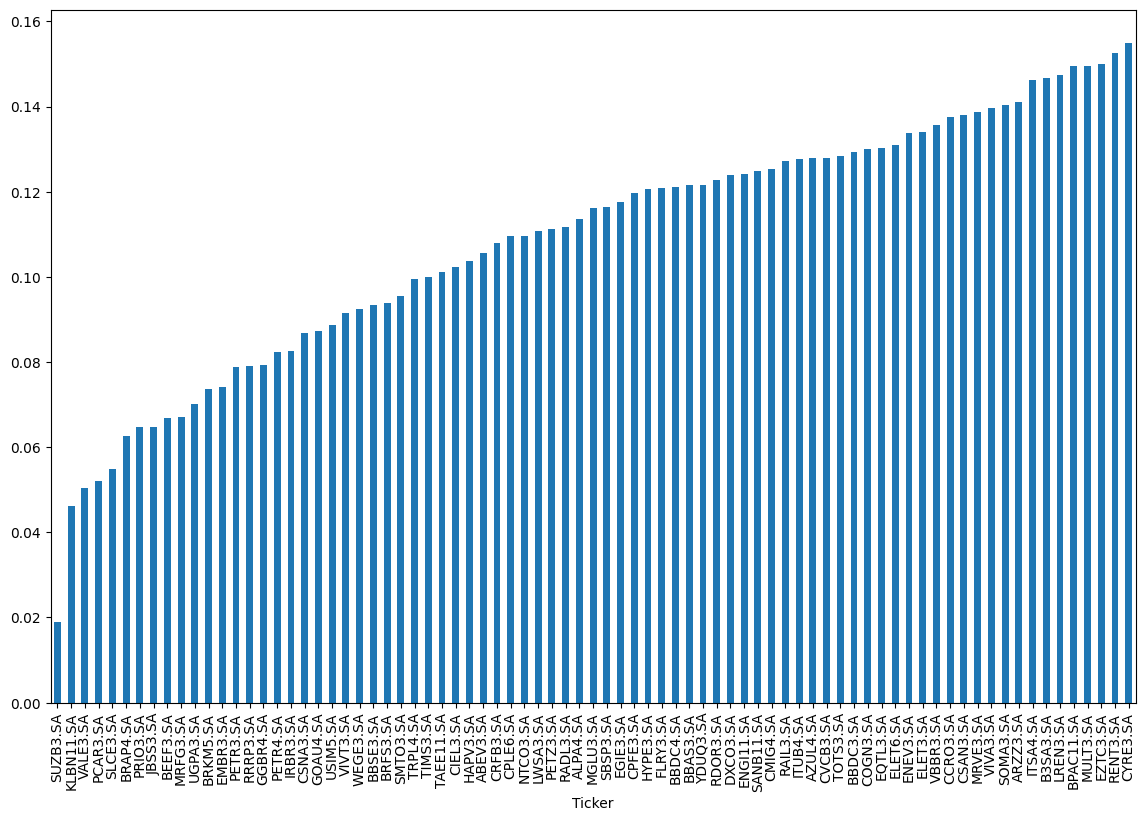

In [ ]:
# cria o df dos fatores
factor_exposures = pd.DataFrame(
    index = ["f1", "f2", "f3", "f4", "f5", "f6", "f7"],
    columns = returns_scaled_df.columns,
    data = pca_components
).T

# cria o gráfico
plt.figure(figsize=(14, 9))
factor_exposures.f1.sort_values().plot.bar()

Uma forma interessante de entender a relação da variabilidade dos retornos por setor, é traçar um gráfico de dispersão em que o eixo x representa o fator 1 e o eixo y representa o fator 2.

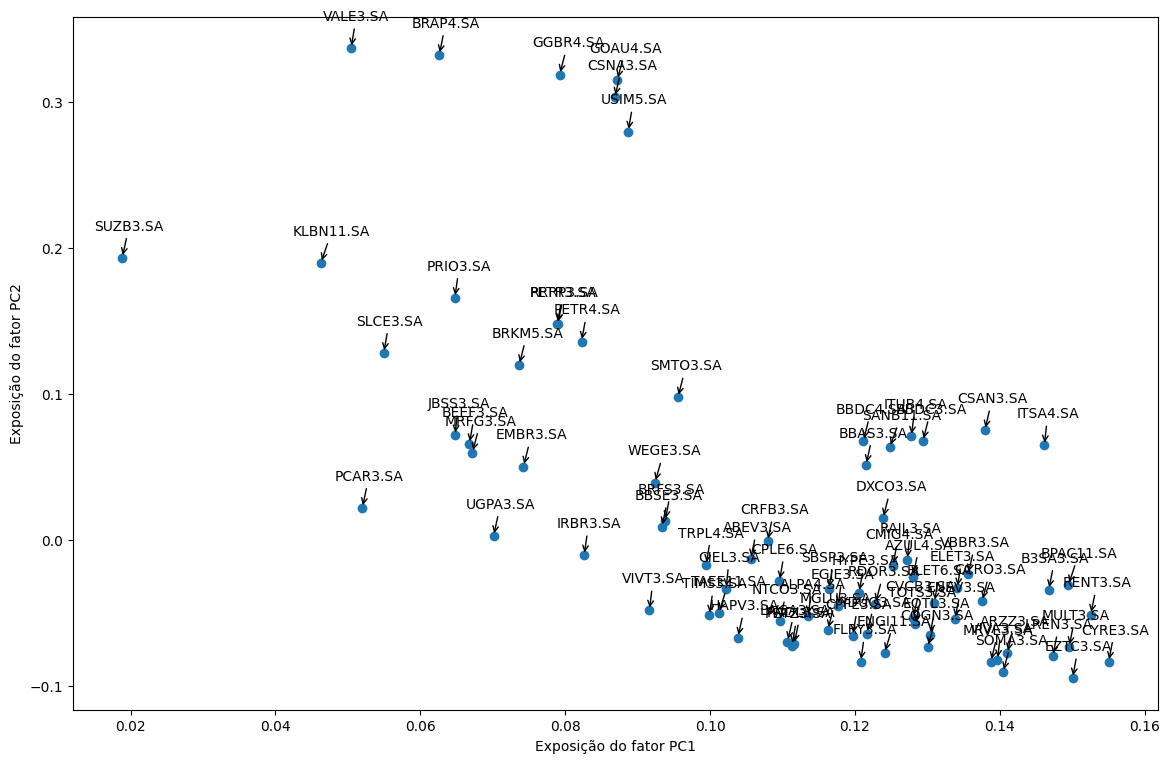

In [ ]:
# Define as labels como os índices das exposições do fator
labels = factor_exposures.index

# Obtém os dados das exposições do fator
data = factor_exposures.values

# Cria um gráfico de dispersão com os dados da primeira coluna (PC1) em relação à segunda coluna (PC2)
plt.figure(figsize=(14, 9))
plt.scatter(data[:, 0], data[:, 1])

# Define o rótulo do eixo x
plt.xlabel('Exposição do fator PC1')

# Define o rótulo do eixo y
plt.ylabel('Exposição do fator PC2')

# Itera sobre as labels e coordenadas (x, y) para adicionar anotações nos pontos do gráfico

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    # Adiciona uma anotação de texto com uma seta para cada ponto
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(-20, 20),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))